# Gradient Boosting Machine (GBM)

### The Core Idea: Learning from Mistakes
Unlike Random Forest, which builds trees in **parallel** (independently), Gradient Boosting builds trees **sequentially** (one after another).

1.  **Tree 1:** Tries to predict the target.
2.  **Tree 2:** Looks at the **errors** (residuals) of Tree 1 and tries to predict *those errors*.
3.  **Tree 3:** Looks at the errors of (Tree 1 + Tree 2) and tries to fix them.

It's like a team of students where each new student focuses specifically on the questions the previous students got wrong.

## Load Dataset (Titanic)
We'll use the classic Titanic dataset. The goal is to predict survival.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load Titanic Dataset (via Seaborn)
df = sns.load_dataset('titanic')

# Preprocessing
# 1. Drop irrelevant/too many missing columns
df = df.drop(['deck', 'embark_town', 'alive', 'class', 'who', 'adult_male'], axis=1)

# 2. Drop rows with missing Embarked
df = df.dropna(subset=['embarked'])

# 3. Fill missing Age with median
df['age'] = df['age'].fillna(df['age'].median())

# 4. Encode Categorical Variables
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['embarked'] = df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df['alone'] = df['alone'].astype(int)

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (889, 9)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,0,3,0,22.0,1,0,7.2500,0,0
1,1,1,1,38.0,1,0,71.2833,1,0
2,1,3,1,26.0,0,0,7.9250,0,1
3,1,1,1,35.0,1,0,53.1000,0,0
4,0,3,0,35.0,0,0,8.0500,0,1


## Gradient Boosting vs. Single Decision Tree
Can a sequence of "weak learners" beat a single "strong learner"?

In [14]:
X = df.drop('survived', axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Single Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)

# 2. Gradient Boosting
# n_estimators=100: Build 100 sequential trees
# learning_rate=0.1: How big of a step to take towards fixing the error
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)
pred_gbm = gbm.predict(X_test)

print(f"Single Decision Tree Accuracy: {accuracy_score(y_test, pred_tree):.4f}")
print(f"Gradient Boosting Accuracy:    {accuracy_score(y_test, pred_gbm):.4f}")

Single Decision Tree Accuracy: 0.7472
Gradient Boosting Accuracy:    0.8146


## Important Hyperparameters
- **Learning Rate:** Controls how strongly each tree tries to correct the previous errors. 
    - *High rate* = fast learning, risk of overfitting.
    - *Low rate* = slow learning, requires more trees, generally better generalization.
- **n_estimators:** Number of trees. Unlike Random Forest, increasing this too much can lead to overfitting because the model gets obsessed with correcting outliers.

# A Visual Deep Dive: Why did it work like that?

The accuracy above (Titanic) was similar because the dataset might not be complex enough, or a single tree was already "good enough."

To **really** see Boosting in action, we need to look at **Regression** (predicting numbers), where we can see the model "sculpting" the prediction line.

### The "Golf" Analogy
Imagine you are putting a golf ball toward a hole 100 yards away.

1.  **Tree 1 (The Drive):** You hit the ball. It goes 80 yards. 
    - **Error (Residual):** You are 20 yards short ($100 - 80 = 20$).
2.  **Tree 2 (The Approach):** You don't aim for the hole anymore. You aim for the **Error** (20 yards). You hit it 15 yards.
    - **New Prediction:** $80 + 15 = 95$ yards.
    - **New Error:** 5 yards short.
3.  **Tree 3 (The Putt):** You aim for the 5 yards. You hit it 4 yards.
    - **New Prediction:** $95 + 4 = 99$ yards.

**Gradient Boosting** does exactly this. It fits new trees to the **residuals** (errors) of the previous prediction.

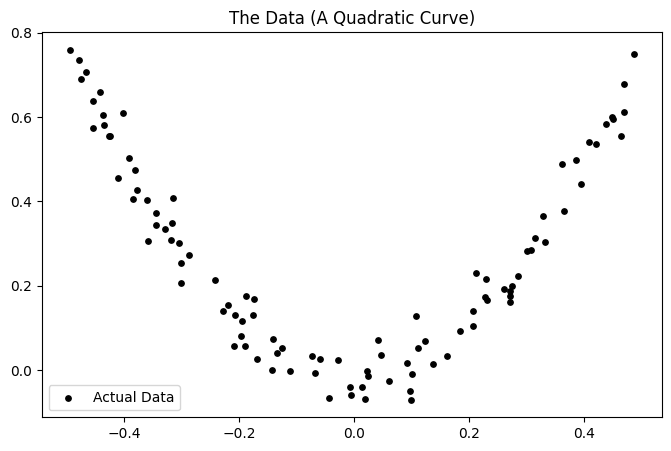

In [15]:
from sklearn.tree import DecisionTreeRegressor

# 1. Create Synthetic Data (A Curve with Noise)
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='black', s=15, label='Actual Data')
plt.title("The Data (A Quadratic Curve)")
plt.legend()
plt.show()

### Step 1: The First Tree (Weak learner)
We fit a very simple tree (depth=2). It barely captures the curve.

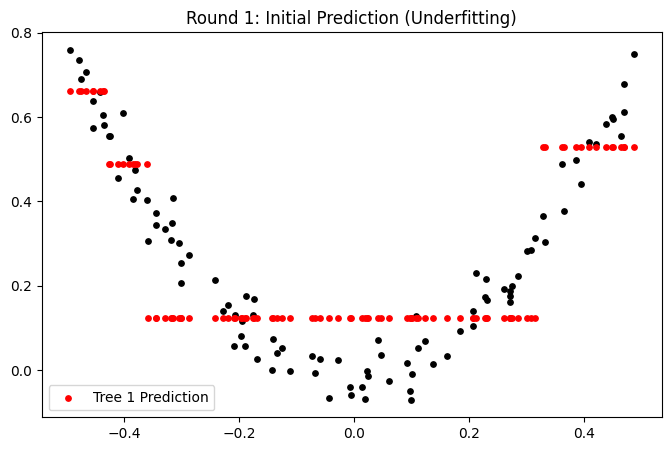

In [16]:
tree_1 = DecisionTreeRegressor(max_depth=2)
tree_1.fit(X, y)

# Predict
y_pred_1 = tree_1.predict(X)

# Visualize
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='black', s=15)
plt.scatter(X, y_pred_1, color='red', s=15, label='Tree 1 Prediction')
plt.title("Round 1: Initial Prediction (Underfitting)")
plt.legend()
plt.show()

### Step 2: Calculate Residuals & Train on THEM
We subtract the prediction from the actual target: $r_1 = y - y_{pred1}$.
Then we train Tree 2 to predict $r_1$.

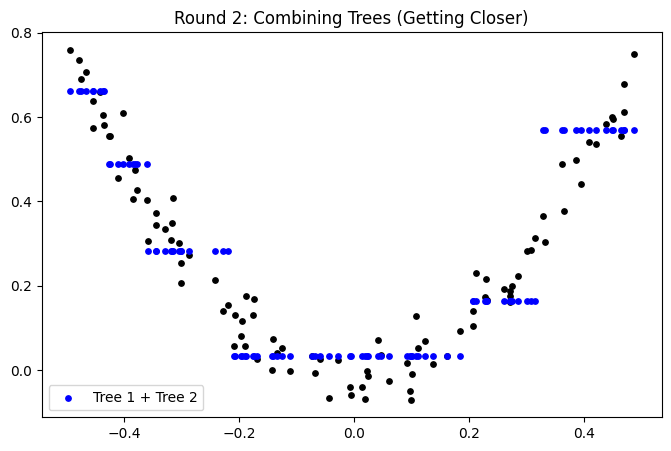

In [17]:
# Calculate Error
y2 = y - y_pred_1

# Train Tree 2 on the ERROR, not the original target
tree_2 = DecisionTreeRegressor(max_depth=2)
tree_2.fit(X, y2)
y_pred_2 = tree_2.predict(X)

# Combine Predictions: Pred_Final = Pred_1 + Pred_2
y_pred_combined = y_pred_1 + y_pred_2

plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='black', s=15)
plt.scatter(X, y_pred_combined, color='blue', s=15, label='Tree 1 + Tree 2')
plt.title("Round 2: Combining Trees (Getting Closer)")
plt.legend()
plt.show()

### Step 3: Repeat!
Now we calculate the error of the *combined* prediction ($y - y_{combined}$) and train Tree 3 on that. 

If we do this 100 times, we get the smooth curve of **Gradient Boosting**.

In [18]:
# Doing it automatically using sklearn
gbm_reg = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=42)
# Note: We can't plot the classifier line easily for classification, 
# but mathematically, it's doing exactly what we did above: summing up small corrections.

# A Complex Challenge: Handwritten Digits (MNIST)

The Titanic dataset was "too easy"

To see the power of Boosting, we need a dataset where **simple rules fail**.

**The Dataset:** 8x8 pixel images of handwritten digits (0-9).
- **Features:** 64 columns (pixel intensity).
- **Complexity:** A single line rule (e.g., "pixel 10 > 5") is not enough to distinguish a '3' from an '8'.

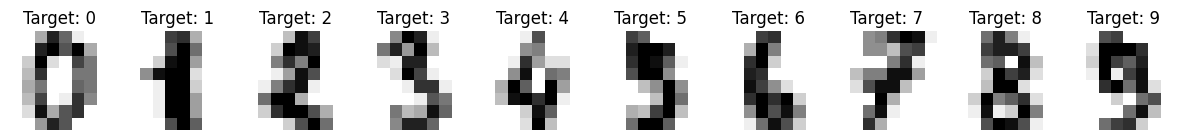

In [19]:
from sklearn.datasets import load_digits

# Load Data
digits = load_digits()

# Visualize a few digits
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Target: {label}')
plt.show()

### The Showdown: Tree vs. Boosting
We expect the single Decision Tree to struggle (~85% accuracy) because it can't capture the complex interaction between 64 pixels.
We expect Gradient Boosting to excel (~96% accuracy) by iteratively correcting mistakes on hard-to-read digits.

In [20]:
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
acc_tree = accuracy_score(y_test, tree.predict(X_test))

# 2. Gradient Boosting
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm.fit(X_train, y_train)
acc_gbm = accuracy_score(y_test, gbm.predict(X_test))

print(f"Decision Tree Accuracy:     {acc_tree:.4f}")
print(f"Gradient Boosting Accuracy: {acc_gbm:.4f}")
print(f"Improvement:                +{(acc_gbm - acc_tree)*100:.1f}%")

Decision Tree Accuracy:     0.8417
Gradient Boosting Accuracy: 0.9694
Improvement:                +12.8%


# The Algorithm: Step-by-Step Intuition

formal recipe for Gradient Boosting, translated into plain English.

### Step 1: The Baseline (The Average)
**Math:** $F_0(x) = \text{argmin}_\gamma \sum L(y, \gamma)$
**Intuition:** Start with a dumb guess. For regression, just guess the **average** of all values. For classification, guess the log-odds of the most common class.

### Step 2: Calculate Errors (Pseudo-Residuals)
**Math:** $r_{im} = -[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}]$
**Intuition:** Calculate how far off we are. 
- If the target is 100 and we predicted 80, the residual is $+20$.
- This "residual" is effectively the **Negative Gradient** of the loss function (hence the name *Gradient* Boosting).

### Step 3: Train a Weak Learner
**Math:** Train $h_m(x)$ on $\{(x_i, r_{im})\}$
**Intuition:** Build a small Decision Tree (a "weak learner") where the input features are the same, but the **target** is the **Residual** from Step 2.

### Step 4: Calculate the Multiplier (Learning Rate / Gamma)
**Math:** $\gamma_m = \text{argmin}_\gamma \sum L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$
**Intuition:** We don't want to fully trust this new tree (it might overfit). We scale its prediction by a small **Learning Rate** (e.g., 0.1).

### Step 5: Update the Model
**Math:** $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$
**Intuition:** Add the new scaled tree to our running total.
$$ \text{New Prediction} = \text{Old Prediction} + (0.1 \times \text{Tree Prediction}) $$

### Step 6: Repeat
Go back to Step 2, using the new predictions to calculate new residuals. Repeat 100-1000 times.